In [1]:
# =========================================================
# 🔧 Imports projet (p9dg + metrics) — chemin propre
# =========================================================
import sys, os
from pathlib import Path

# Racine du projet (remappée dans ton environnement)
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "/workspace")).resolve()

# 👉 On ajoute UNIQUEMENT la racine du projet
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f"PROJECT_ROOT = {PROJECT_ROOT}")

# Assure-toi d'avoir __init__.py dans p9dg/ et metrics/
# p.ex. `touch /workspace/p9dg/__init__.py` et `touch /workspace/metrics/__init__.py`

# Imports package-qualifiés
from p9dg.histo_dataset import HistoDataset
print("✅ Import HistoDataset depuis p9dg")

from metrics.cnn_eval import run_eval_split
print("✅ Import cnn_eval depuis metrics")


PROJECT_ROOT = /workspace
✅ Import HistoDataset depuis p9dg
✅ Import cnn_eval depuis metrics


## 🧩 Cellule 2 — Paths & sanity-check

In [2]:
# =========================================================
# 📂 Chemins vers les artefacts sauvegardés
# =========================================================
from pathlib import Path

VAL_RAW_CSV = Path("/workspace/outputs/baseline/mobilenetv2_preds_val.csv")
VAL_CAL_CSV = Path("/workspace/outputs/baseline/mobilenetv2_preds_val_calibrated.csv")  # optionnel
TEMP_JSON   = Path("./artifacts/mobilenetv2_temp_scaling.json")  # T appris

OUT_DIR = Path("/workspace/outputs/baseline/downstream_eval_test")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("VAL_RAW_CSV    :", VAL_RAW_CSV, "→", VAL_RAW_CSV.exists())
print("VAL_CAL_CSV    :", VAL_CAL_CSV, "→", VAL_CAL_CSV.exists())
print("TEMP_JSON (T)  :", TEMP_JSON,   "→", TEMP_JSON.exists())
print("OUT_DIR        :", OUT_DIR)


VAL_RAW_CSV    : /workspace/outputs/baseline/mobilenetv2_preds_val.csv → True
VAL_CAL_CSV    : /workspace/outputs/baseline/mobilenetv2_preds_val_calibrated.csv → True
TEMP_JSON (T)  : artifacts/mobilenetv2_temp_scaling.json → True
OUT_DIR        : /workspace/outputs/baseline/downstream_eval_test


## 📊 Cellule 3 — Évaluation du CSV val (raw + calibration T)

In [4]:
from pathlib import Path
import json

TEMP_JSON = Path("./artifacts/mobilenetv2_temp_scaling.json")  # adapte si besoin
assert TEMP_JSON.exists(), f"Introuvable: {TEMP_JSON}"

with open(TEMP_JSON, "r") as f:
    obj = json.load(f)

assert "temperature" in obj and isinstance(obj["temperature"], (int, float)) and obj["temperature"] > 0, \
    f"JSON invalide: {obj}"

print(f"T chargé = {float(obj['temperature']):.6f}")


T chargé = 0.998820


In [5]:
# =========================================================
# 📊 Évaluation depuis le CSV (aucune inférence)
# =========================================================
from metrics.cnn_eval import evaluate_csv_metrics

report = evaluate_csv_metrics(
    csv_path=VAL_RAW_CSV,
    classes=None,            # auto (à partir du nb de classes dans logits)
    class_to_idx=None,       # si tu veux imposer un mapping tu peux le passer ici
    temp_json=TEMP_JSON,     # ← applique T pour ECE/Brier calibrés
    out_dir=OUT_DIR,
    normalize_cm=False,
    plot=True
)

print(f"[{report.split}] n={report.n}")
print(f"- Acc (micro)         : {report.acc_micro:.4f}")
print(f"- F1 (macro)          : {report.f1_macro:.4f}")
print(f"- ECE (raw)           : {report.ece_raw:.4f}")
print(f"- ECE (calibrée)      : {report.ece_cal if report.ece_cal is not None else float('nan'):.4f}")
print(f"- Brier (raw)         : {report.brier_raw:.4f}")
print(f"- Brier (calibré)     : {report.brier_cal if report.brier_cal is not None else float('nan'):.4f}")
print(f"- CM png              : {report.cm_path}")
print(f"- Reliability png     : {report.reliability_path}")


[val] n=90
- Acc (micro)         : 0.7778
- F1 (macro)          : 0.7376
- ECE (raw)           : 0.1022
- ECE (calibrée)      : 0.1021
- Brier (raw)         : 0.3056
- Brier (calibré)     : 0.3056
- CM png              : /workspace/outputs/baseline/downstream_eval_test/cm_val.png
- Reliability png     : /workspace/outputs/baseline/downstream_eval_test/reliability_val.png


## 🧾 Cellule 4 — Rapport de classification lisible

In [6]:
# =========================================================
# 🧾 Rapport de classification
# =========================================================
print(report.classification_report)


              precision    recall  f1-score   support

     class_0      1.000     0.800     0.889        10
     class_1      0.833     1.000     0.909        10
     class_2      0.769     1.000     0.870        10
     class_3      0.833     1.000     0.909        10
     class_4      0.727     0.800     0.762        10
     class_5      0.500     0.800     0.615        10
     class_6      0.778     0.700     0.737        10
     class_7      0.000     0.000     0.000        10
     class_8      1.000     0.900     0.947        10

    accuracy                          0.778        90
   macro avg      0.716     0.778     0.738        90
weighted avg      0.716     0.778     0.738        90



## 🧪 Cellule 5 — Comparer avec le CSV “calibrated”

In [7]:
# =========================================================
# 🔁 Évalue aussi le CSV "calibrated" (cohérence)
# =========================================================
if VAL_CAL_CSV.exists():
    report_calcsv = evaluate_csv_metrics(
        csv_path=VAL_CAL_CSV,
        temp_json=TEMP_JSON,
        out_dir=OUT_DIR,
        plot=False
    )
    print(f"[{report_calcsv.split}] Acc={report_calcsv.acc_micro:.4f} | ECE_raw={report_calcsv.ece_raw:.4f} | ECE_cal={report_calcsv.ece_cal:.4f}")
else:
    print("CSV calibré absent → on saute ce check.")


[val] Acc=0.7778 | ECE_raw=0.1022 | ECE_cal=0.1021


In [10]:
# =========================================================
# 🔗 Paires real↔synth (CSV racine)
# =========================================================
from pathlib import Path
import pandas as pd

PAIRS_CSV = Path("/workspace/notebooks/outputs_pixcell_synth/pairs_real_synth.csv")

pairs = pd.read_csv(PAIRS_CSV)
print(f"[OK] pairs: {PAIRS_CSV} — {len(pairs)} lignes")
print("Colonnes :", list(pairs.columns))

# On standardise quelques noms attendus
# (dans tes CSV on a en général: split, class, real_path, synth_path, src_path, seed, guidance)
needed = {"real_path", "synth_path"}
missing = needed - set([c.lower() for c in pairs.columns])
if missing:
    raise ValueError(f"Colonnes requises manquantes dans pairs CSV: {missing}")

# Juste pour contrôle visuel
display(pairs.head(3))


[OK] pairs: /workspace/notebooks/outputs_pixcell_synth/pairs_real_synth.csv — 630 lignes
Colonnes : ['split', 'class', 'real_path', 'synth_path', 'src_path', 'seed', 'guidance']


,split,class,real_path,synth_path,src_path,seed,guidance
0,train,ADI,/workspace/notebooks/outputs_pixcell_synth/tra...,/workspace/notebooks/outputs_pixcell_synth/tra...,/workspace/data/NCT-CRC-HE-100K/ADI/ADI-AAAMHQ...,123,1.5
1,train,ADI,/workspace/notebooks/outputs_pixcell_synth/tra...,/workspace/notebooks/outputs_pixcell_synth/tra...,/workspace/data/NCT-CRC-HE-100K/ADI/ADI-AACCGL...,124,1.5
2,train,ADI,/workspace/notebooks/outputs_pixcell_synth/tra...,/workspace/notebooks/outputs_pixcell_synth/tra...,/workspace/data/NCT-CRC-HE-100K/ADI/ADI-AACVGR...,125,1.5


In [10]:
# =========================================================
# ⚙️ Config & classes
# =========================================================
from pathlib import Path
import torch

# Checkpoints & données
CKPT_PATH   = Path("./artifacts/mobilenetv2_best_ts.pt")
PAIRS_CSV   = Path("/workspace/notebooks/outputs_pixcell_synth/pairs_real_synth.csv")
OUT_DIR     = Path("/workspace/outputs/baseline")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Paramètres modèle / préproc (aligne-les avec l'entraînement)
IMG_SIZE     = 128
PIXEL_RANGE  = "imagenet"   # 'imagenet' ou '0_1' ou '-1_1' selon ton entraînement
BATCH_SIZE   = 8
NUM_WORKERS  = 0

# Ordre des classes utilisé par le modèle
CLASSES = ['ADI','BACK','DEB','LYM','MUC','MUS','NORM','STR','TUM']
class_to_idx = {c:i for i,c in enumerate(CLASSES)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CKPT_PATH:", CKPT_PATH, CKPT_PATH.exists())
print("PAIRS_CSV:", PAIRS_CSV, PAIRS_CSV.exists())
print("OUT_DIR  :", OUT_DIR)
print("DEVICE   :", DEVICE)


CKPT_PATH: artifacts/mobilenetv2_best_ts.pt True
PAIRS_CSV: /workspace/notebooks/outputs_pixcell_synth/pairs_real_synth.csv True
OUT_DIR  : /workspace/outputs/baseline
DEVICE   : cuda


In [11]:
# =========================================================
# 📦 Chargement modèle (TorchScript ou state_dict MobileNetV2)
# =========================================================
import torch
import torch.nn as nn

def load_model_mobilenet_v2_state_dict(state):
    from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
    # On part d'un backbone (pré-entraîné ou non), puis on remplace la tête
    m = mobilenet_v2(weights=None)  # tu peux mettre weights=MobileNet_V2_Weights.IMAGENET1K_V1 si utile
    in_feat = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_feat, len(CLASSES))
    missing = m.load_state_dict(state, strict=False)
    print("State-dict chargé (strict=False). Missing/Unexpected:", missing)
    return m

def load_cnn_model(ckpt_path: Path, device: torch.device):
    # 1) TorchScript
    try:
        model = torch.jit.load(str(ckpt_path), map_location=device)
        model.eval().to(device)
        print("[OK] TorchScript chargé.")
        return model
    except Exception as e:
        print("[i] TorchScript non détecté:", e)

    # 2) Objet torch.save(...) → state_dict direct
    obj = torch.load(str(ckpt_path), map_location=device)
    if isinstance(obj, dict) and all(isinstance(k, str) for k in obj.keys()):
        # Deux cas fréquents: {'model_state_dict':...} ou directement le state_dict
        if 'model_state_dict' in obj and isinstance(obj['model_state_dict'], dict):
            state = obj['model_state_dict']
        else:
            state = obj
        model = load_model_mobilenet_v2_state_dict(state)
        model.eval().to(device)
        print("[OK] Modèle reconstruit (MobileNetV2 + state_dict).")
        return model

    # 3) Modèle picklé
    if hasattr(obj, "eval") and hasattr(obj, "forward"):
        obj.eval().to(device)
        print("[OK] Modèle picklé chargé.")
        return obj

    raise RuntimeError("Format de checkpoint non reconnu.")

model = load_cnn_model(CKPT_PATH, DEVICE)
# Dry-run
_ = model(torch.randn(1,3,IMG_SIZE,IMG_SIZE, device=DEVICE))
print("Sanity forward OK")


[OK] TorchScript chargé.
Sanity forward OK


## 🧾 Cellule — Dataset depuis le CSV des paires (réel & synth)

In [13]:
# =========================================================
# 🧾 Dataset à partir des chemins du CSV des paires
# =========================================================
import pandas as pd
import numpy as np
from PIL import Image

pairs = pd.read_csv(PAIRS_CSV)
print(f"[OK] pairs.csv: {len(pairs)} lignes — colonnes: {list(pairs.columns)}")

# Colonnes attendues
def _col(df, name):
    for c in df.columns:
        if c.lower() == name:
            return c
    # fallback par inclusion
    for c in df.columns:
        if name in c.lower():
            return c
    raise ValueError(f"Colonne '{name}' non trouvée dans {list(df.columns)}")

COL_REAL  = _col(pairs, "real_path")
COL_SYNTH = _col(pairs, "synth_path")
COL_CLASS = _col(pairs, "class") if any(c.lower()=="class" for c in pairs.columns) else None

# Listes uniques de chemins
real_paths  = sorted(set(map(str, pairs[COL_REAL].tolist())))
synth_paths = sorted(set(map(str, pairs[COL_SYNTH].tolist())))

def _map_y_true_from_name(path):
    # Essaie d'inférer le label depuis la colonne 'class' du pairs.csv si dispo.
    # Sinon, tente de deviner via le dossier parent (ADI/BACK/...) présent dans le chemin.
    if COL_CLASS is not None:
        # On fait un lookup par real_path exact; sinon basename
        return None  # on va le gérer après avec un LUT
    # Heuristique chemin
    up = path.upper()
    for cname in CLASSES:
        if f"/{cname}/" in up or f"\\{cname}\\" in up or up.endswith(f"/{cname}") or up.endswith(f"\\{cname}"):
            return class_to_idx[cname]
    return None

# LUT(s) pour y_true si 'class' dispo
lut_real_true, lut_synth_true = {}, {}
if COL_CLASS is not None:
    # on part des lignes et remplit deux LUT par chemin complet et par basename
    for _, r in pairs.iterrows():
        cls = str(r[COL_CLASS]).upper() if not pd.isna(r[COL_CLASS]) else None
        yi  = class_to_idx.get(cls, None) if cls else None
        rp  = str(r[COL_REAL]); gp = str(r[COL_SYNTH])
        for d, pth in [("r", rp), ("g", gp)]:
            if yi is not None:
                (lut_real_true if d=="r" else lut_synth_true)[pth] = yi
                (lut_real_true if d=="r" else lut_synth_true)[Path(pth).name] = yi

# Dataset PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

class PathsDataset(Dataset):
    def __init__(self, paths, domain, img_size=256, pixel_range="imagenet"):
        self.paths = list(paths)
        self.domain = domain  # "real" | "synth"
        self.img_size = img_size
        self.pixel_range = pixel_range

    def __len__(self):
        return len(self.paths)

    @staticmethod
    def _read_rgb(path):
        img = Image.open(path)
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

    def _resize(self, img):
        return img.resize((self.img_size, self.img_size), Image.BILINEAR)

    def _to_tensor(self, img):
        arr = np.asarray(img, dtype=np.float32) / 255.0
        arr = np.transpose(arr, (2,0,1))
        t = torch.from_numpy(arr)

        if self.pixel_range == "imagenet":
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
            t = (t - mean) / std
        elif self.pixel_range == "-1_1":
            t = (t * 2.0) - 1.0

        return t

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = self._read_rgb(p)
        img = self._resize(img)
        x = self._to_tensor(img)

        # y_true optionnel
        yi = None
        if COL_CLASS is not None:
            lut = lut_real_true if self.domain == "real" else lut_synth_true
            yi = lut.get(p, lut.get(Path(p).name, None))
        if yi is None:
            yi = _map_y_true_from_name(p)

        return x, (yi if yi is not None else -1), p

ds_real  = PathsDataset(real_paths,  domain="real",  img_size=IMG_SIZE, pixel_range=PIXEL_RANGE)
ds_synth = PathsDataset(synth_paths, domain="synth", img_size=IMG_SIZE, pixel_range=PIXEL_RANGE)

dl_real  = DataLoader(ds_real,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                      pin_memory=True, drop_last=False)
dl_synth = DataLoader(ds_synth, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                      pin_memory=True, drop_last=False)

len(ds_real), len(ds_synth)


[OK] pairs.csv: 630 lignes — colonnes: ['split', 'class', 'real_path', 'synth_path', 'src_path', 'seed', 'guidance']


(630, 630)

## 🚀 Cellule — Inférence (AMP), export CSV (logits + top1_conf)

In [14]:
# =========================================================
# 🚀 Inférence & export CSV (real / synth)
# =========================================================
import json
import pandas as pd
import torch
import torch.nn.functional as F
from pathlib import Path
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = lambda x, **k: x  # fallback silencieux

OUT_INFER_DIR = OUT_DIR / "pixcell_infer"
OUT_INFER_DIR.mkdir(parents=True, exist_ok=True)

FNAME_PREFIX = "mobilenetv2"  # adapte si besoin

# Détermine un nom de split lisible à partir du CSV des paires
split_name = "pix"
try:
    if "split" in pairs.columns and pairs["split"].nunique() == 1:
        split_name = str(pairs["split"].iloc[0]).lower()
except Exception:
    pass

@torch.no_grad()
def infer_to_csv(dataloader, domain: str, split: str, fname_prefix: str = FNAME_PREFIX):
    rows = []
    use_amp = (DEVICE.type == "cuda")
    model.eval()
    for xb, yb, paths in tqdm(dataloader, desc=f"Infer {domain}", leave=False):
        xb = xb.to(DEVICE, non_blocking=True).contiguous(memory_format=torch.channels_last)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
            logits = model(xb)
            probs  = F.softmax(logits, dim=1)
            conf, yhat = probs.max(dim=1)

        for i in range(xb.size(0)):
            rows.append({
                "split": split,
                "image_path": str(paths[i]),
                "y_true": int(yb[i]),
                "y_pred": int(yhat[i]),
                "top1_conf": float(conf[i]),
                "logits_json": json.dumps(logits[i].float().cpu().tolist(), separators=(",", ":")),
            })

    df = pd.DataFrame(rows)
    out_csv = OUT_INFER_DIR / f"{fname_prefix}_preds_{split}_{domain}.csv"
    df.to_csv(out_csv, index=False)
    print(f"[OK] {domain}: {out_csv} ({len(df)} lignes)")
    return df, out_csv

# Lance l'inférence sur les deux domaines
df_real,  csv_real  = infer_to_csv(dl_real,  domain="real",  split=split_name)
df_synth, csv_synth = infer_to_csv(dl_synth, domain="synth", split=split_name)


Infer real:   0%|          | 0/79 [00:00<?, ?it/s]

[OK] real: /workspace/outputs/baseline/pixcell_infer/mobilenetv2_preds_pix_real.csv (630 lignes)


Infer synth:   0%|          | 0/79 [00:00<?, ?it/s]

[OK] synth: /workspace/outputs/baseline/pixcell_infer/mobilenetv2_preds_pix_synth.csv (630 lignes)


## ✅ Cellule — PCR (réutilise les CSV qu’on vient d’écrire)

In [15]:
# =========================================================
# ✅ PCR (pair consistency) + exports (maj noms)
# =========================================================
import pandas as pd, os, numpy as np
from pathlib import Path

# 1) Charger les CSV de prédictions produits juste avant
real_df  = pd.read_csv(csv_real)
synth_df = pd.read_csv(csv_synth)

# 2) Choisir le DataFrame de paires (pairs_use si filtré, sinon pairs)
pairs_df = pairs_use if 'pairs_use' in globals() else pairs

# 3) Colonnes normalisées (réutilise celles déjà définies si dispo)
def _norm_col(df, name):
    for c in df.columns:
        if c.lower() == name:
            return c
    for c in df.columns:
        if name in c.lower():
            return c
    raise KeyError(f"Colonne introuvable pour '{name}' dans {list(df.columns)}")

COL_REAL  = COL_REAL  if 'COL_REAL'  in globals() else _norm_col(pairs_df, "real_path")
COL_SYNTH = COL_SYNTH if 'COL_SYNTH' in globals() else _norm_col(pairs_df, "synth_path")
COL_CLASS = (COL_CLASS if 'COL_CLASS' in globals() else
             (_norm_col(pairs_df, "class") if any(c.lower()=="class" for c in pairs_df.columns) else None))

# 4) LUTs prédictions (chemin complet et basename)
def _mk_pred_lookup(df):
    path_cols = [c for c in ("image_path","path","filepath","img_path") if c in df.columns]
    key = path_cols[0] if path_cols else "image_path"
    lut = {}
    for _, r in df.iterrows():
        p = str(r[key]); y = int(r["y_pred"])
        lut[p] = y
        lut[os.path.basename(p)] = y
    return lut

lut_r = _mk_pred_lookup(real_df)
lut_g = _mk_pred_lookup(synth_df)

# 5) Calcul PCR
n = agree = miss = 0
rows = []
for _, r in pairs_df.iterrows():
    rp, sp = str(r[COL_REAL]), str(r[COL_SYNTH])
    yr = lut_r.get(rp, lut_r.get(os.path.basename(rp)))
    yg = lut_g.get(sp, lut_g.get(os.path.basename(sp)))
    if yr is None or yg is None:
        miss += 1
        continue
    n += 1
    ok = int(yr == yg)
    agree += ok
    rows.append({
        "real_path": rp,
        "synth_path": sp,
        "y_pred_real": yr,
        "y_pred_synth": yg,
        "agree": ok,
        "pair_class": (str(r[COL_CLASS]).upper() if COL_CLASS else None),
    })

pcr = (agree / n) if n > 0 else float("nan")
print(f"PCR globale: {pcr:.4f} | pairs={n} | missing={miss}")

# 6) PCR par classe + table d'accord (si colonne 'class' dispo)
OUT_PCR_DIR = (OUT_INFER_DIR if 'OUT_INFER_DIR' in globals() else OUT_DIR) / "eval_pcr"
OUT_PCR_DIR.mkdir(parents=True, exist_ok=True)

df_pairs = pd.DataFrame(rows)
df_pairs.to_csv(OUT_PCR_DIR / f"pcr_pairs_detailed_{split_name}.csv", index=False)

if COL_CLASS:
    grp = (df_pairs.dropna(subset=["pair_class"])
                   .groupby("pair_class")["agree"]
                   .agg(["sum","count"])
                   .reset_index()
                   .rename(columns={"sum":"agree","count":"n_pairs"}))
    grp["pcr"] = grp["agree"] / grp["n_pairs"]
    display(grp.sort_values("pair_class"))
    grp.to_csv(OUT_PCR_DIR / f"pcr_per_class_{split_name}.csv", index=False)

# Table ŷ_real vs ŷ_synth
if len(df_pairs):
    ct = pd.crosstab(df_pairs["y_pred_real"], df_pairs["y_pred_synth"])
    display(ct)
    ct.to_csv(OUT_PCR_DIR / f"yhat_real_vs_yhat_synth_{split_name}.csv")


PCR globale: 0.1127 | pairs=630 | missing=0


,pair_class,agree,n_pairs,pcr
0,ADI,3,70,0.042857
1,BACK,54,70,0.771429
2,DEB,2,70,0.028571
3,LYM,2,70,0.028571
4,MUC,0,70,0.000000
5,MUS,1,70,0.014286
6,NORM,2,70,0.028571
7,STR,5,70,0.071429
8,TUM,2,70,0.028571


y_pred_synth,0,1,2,4,5,6,7
y_pred_real,,,,,,,
0,2,48,2,12,0,2,0
1,9,66,1,3,6,0,3
2,1,70,1,4,0,0,0
3,9,46,1,11,1,2,0
4,0,78,0,0,0,0,0
5,3,71,2,4,1,1,1
6,2,66,0,1,1,0,0
7,4,30,0,2,1,0,1
8,11,44,0,5,1,0,0


## 🎯 Cellule — Évaluation rapide (ECE/Brier/CM)

In [17]:
# =========================================================
# ⚡ Évaluation rapide (ECE, Brier, CM, Reliability) — robuste
# =========================================================
from pathlib import Path
from metrics.cnn_eval import evaluate_csv_metrics
import pandas as pd, json

# ➜ Chemins
TEMP_JSON = Path("/workspace/notebooks/artifacts/mobilenetv2_temp_scaling.json")   # requis pour ECE/Brier calibrés
OUT_DIR   = Path("/workspace/outputs/baseline/downstream_eval_test")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 0) Vérifs calibration
assert TEMP_JSON.exists(), f"Temp JSON introuvable: {TEMP_JSON}"
with open(TEMP_JSON, "r") as f:
    obj = json.load(f)
assert "temperature" in obj and float(obj["temperature"]) > 0, f"JSON invalide: {obj}"
print(f"T chargé = {float(obj['temperature']):.6f}")

def _has_logits(csv_path: Path) -> bool:
    try:
        cols = pd.read_csv(csv_path, nrows=0).columns
        return ("logits_json" in cols) or any(c.lower().startswith("logit_") for c in cols)
    except Exception:
        return False

def eval_csv(csv_path: Path, name: str):
    # 1) Sanity: logits présents pour permettre la calibration ?
    if not _has_logits(csv_path):
        print(f"⚠️ {csv_path.name}: pas de logits → ECE/Brier calibrés risquent d'être NaN.")
    # 2) Éval
    rep = evaluate_csv_metrics(
        csv_path=csv_path,
        classes=None,
        class_to_idx=None,
        temp_json=str(TEMP_JSON),  # force string
        out_dir=OUT_DIR / name,
        normalize_cm=False,
        plot=True
    )
    print(f"\n[{name}] n={rep.n}")
    print(f"- Acc (micro)     : {rep.acc_micro:.4f}")
    print(f"- F1 (macro)      : {rep.f1_macro:.4f}")
    print(f"- ECE (raw)       : {rep.ece_raw:.4f}")
    print(f"- ECE (calibrée)  : {(rep.ece_cal if rep.ece_cal is not None else float('nan')):.4f}")
    print(f"- Brier (raw)     : {rep.brier_raw:.4f}")
    print(f"- Brier (calibré) : {(rep.brier_cal if rep.brier_cal is not None else float('nan')):.4f}")
    print(f"- CM png          : {rep.cm_path}")
    print(f"- Reliability png : {rep.reliability_path}")
    try:
        print("\nClassification report:\n", rep.classification_report)
    except Exception:
        pass
    return rep

# ➜ Utilise les CSV produits par l'inférence juste avant
name_prefix = ("val" if 'split_name' not in globals() else str(split_name).lower())
if 'csv_real' in locals() and Path(csv_real).exists():
    rep_real = eval_csv(Path(csv_real),  name=f"{name_prefix}_real")
else:
    print("⚠️ csv_real introuvable. Renseigne le chemin manuel si besoin.")

if 'csv_synth' in locals() and Path(csv_synth).exists():
    rep_synth = eval_csv(Path(csv_synth), name=f"{name_prefix}_synth")
else:
    print("ℹ️ csv_synth absent (normal si tu n'as évalué que le réel). Ajoute-le pour comparer et tracer.")


T chargé = 0.998820

[pix_real] n=630
- Acc (micro)     : 0.8873
- F1 (macro)      : 0.8824
- ECE (raw)       : 0.1044
- ECE (calibrée)  : 0.1053
- Brier (raw)     : 0.1764
- Brier (calibré) : 0.1763
- CM png          : /workspace/outputs/baseline/downstream_eval_test/pix_real/cm_pix.png
- Reliability png : /workspace/outputs/baseline/downstream_eval_test/pix_real/reliability_pix.png

Classification report:
               precision    recall  f1-score   support

     class_0      0.985     0.929     0.956        70
     class_1      0.795     1.000     0.886        70
     class_2      0.882     0.957     0.918        70
     class_3      0.971     0.971     0.971        70
     class_4      0.885     0.986     0.932        70
     class_5      0.723     0.857     0.784        70
     class_6      0.914     0.914     0.914        70
     class_7      0.921     0.500     0.648        70
     class_8      1.000     0.871     0.931        70

    accuracy                          0.887   

### Où le modèle “colle” sur le synth ?

Répartition y_pred — synth (proportions) :
y_pred
0    0.065
1    0.824
2    0.011
4    0.067
5    0.017
6    0.008
7    0.008
Name: proportion, dtype: float64

Confiances moyennes :
  real : 0.7886476070398376
  synth: 0.6373888798412822

Top erreurs très confiantes retenues: 10


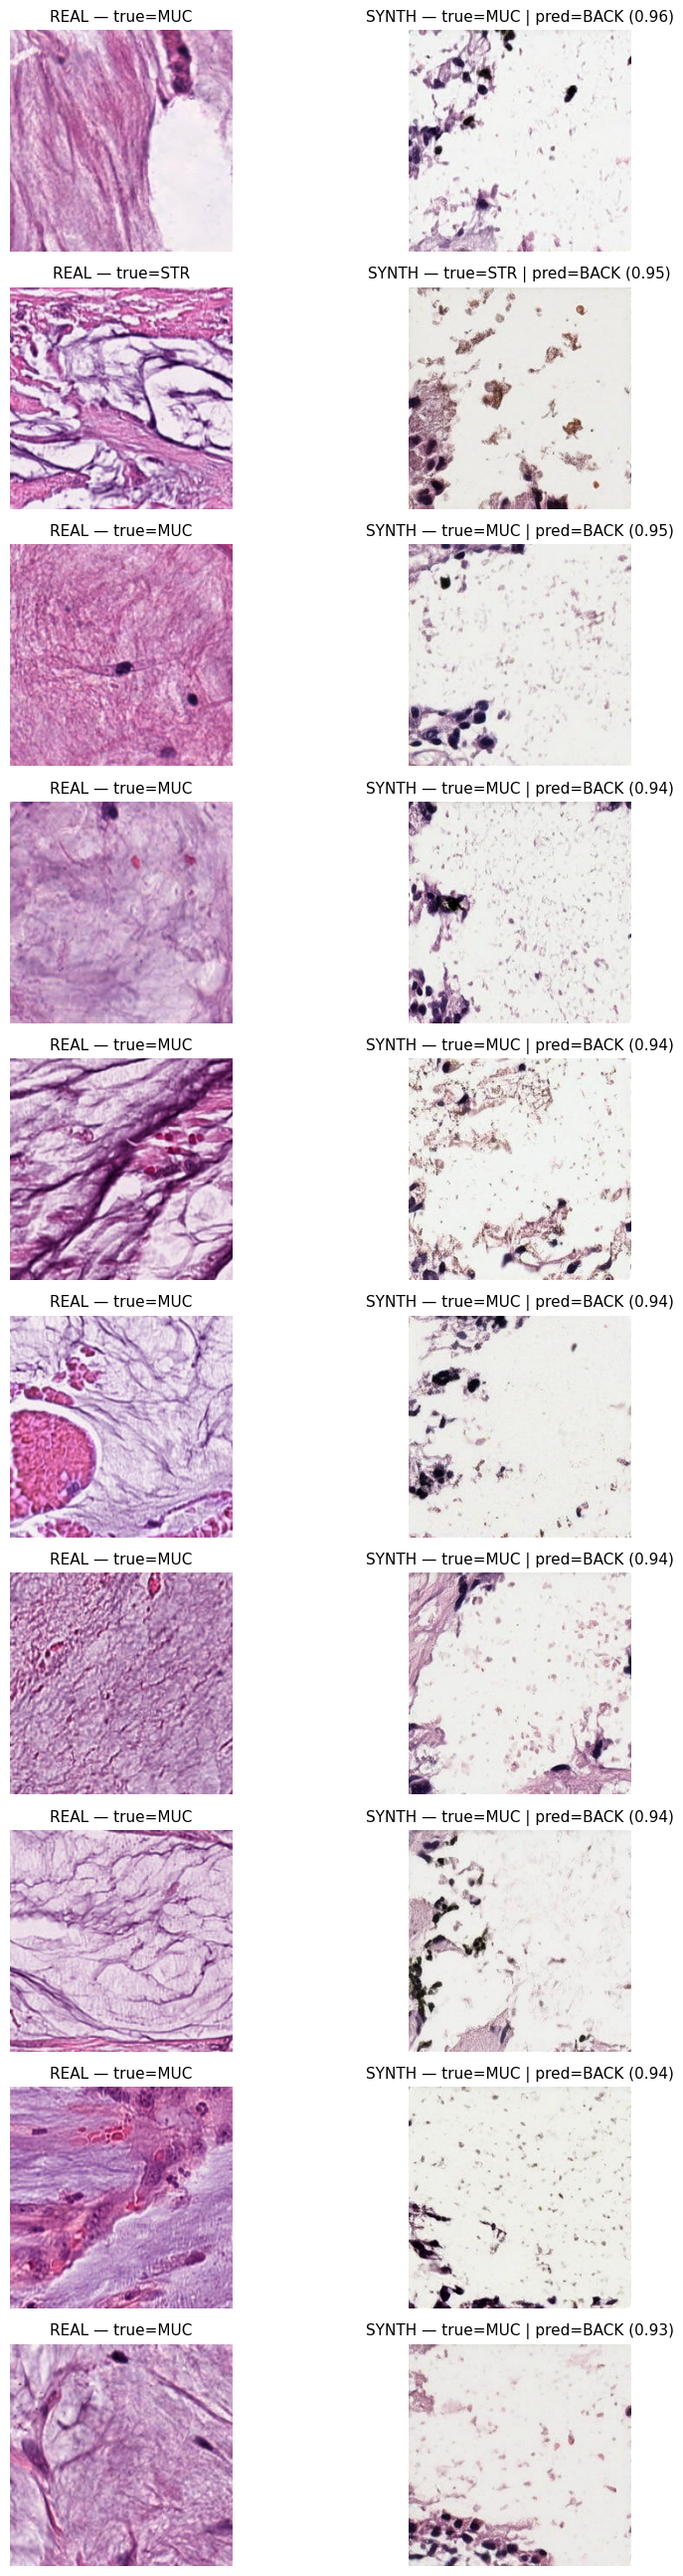

In [21]:
# =========================================================
# 🔎 Top 10 erreurs très confiantes (affichage paires)
# =========================================================
import pandas as pd, numpy as np, os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# csv_synth et csv_real viennent de la cellule d'inférence
df_s  = pd.read_csv(csv_synth)
df_r  = pd.read_csv(csv_real)

print("Répartition y_pred — synth (proportions) :")
print((df_s["y_pred"].value_counts(normalize=True).sort_index()).round(3))

print("\nConfiances moyennes :")
print("  real :", float(df_r["top1_conf"].mean()))
print("  synth:", float(df_s["top1_conf"].mean()))

# Paires (on prend pairs_use si défini, sinon pairs)
pairs_df = pairs_use if 'pairs_use' in globals() else pairs

# LUTs: synth_path -> real_path / class
def _build_pair_luts(pdf):
    col_real  = next(c for c in pdf.columns if c.lower()=="real_path")
    col_synth = next(c for c in pdf.columns if c.lower()=="synth_path")
    col_class = next((c for c in pdf.columns if c.lower()=="class"), None)
    lut_s2r, lut_s2c = {}, {}
    for _, r in pdf.iterrows():
        sp = str(r[col_synth]); rp = str(r[col_real])
        lut_s2r[sp] = rp
        lut_s2r[os.path.basename(sp)] = rp
        if col_class is not None:
            cls = str(r[col_class]).upper()
            lut_s2c[sp] = cls
            lut_s2c[os.path.basename(sp)] = cls
    return lut_s2r, lut_s2c

lut_synth2real, lut_synth2class = _build_pair_luts(pairs_df)

# Mapping idx -> nom de classe (si pas déjà présent)
if 'idx_to_class' not in globals():
    assert 'CLASSES' in globals(), "CLASSES doit être défini"
    idx_to_class = {i:c for i,c in enumerate(CLASSES)}

# Sélection top-10 erreurs synth les plus confiantes
bad = df_s[df_s["y_pred"] != df_s["y_true"]].copy()
bad["err_conf"] = bad["top1_conf"]
top_bad = bad.sort_values("err_conf", ascending=False).head(10).reset_index(drop=True)

# Prépare les paires (real_path associé)
rows = []
for _, r in top_bad.iterrows():
    sp = str(r["image_path"])
    rp = lut_synth2real.get(sp, lut_synth2real.get(os.path.basename(sp)))
    if rp is None:  # si on ne trouve pas la paire, on skip
        continue
    rows.append({
        "synth_path": sp,
        "real_path": rp,
        "y_true_idx": int(r["y_true"]),
        "y_pred_idx": int(r["y_pred"]),
        "conf": float(r["top1_conf"]),
        "y_true_name": idx_to_class.get(int(r["y_true"]), lut_synth2class.get(sp, "UNK")),
        "y_pred_name": idx_to_class.get(int(r["y_pred"]), "UNK"),
    })

print(f"\nTop erreurs très confiantes retenues: {len(rows)}")

# Affichage des paires
n = len(rows)
if n == 0:
    print("Aucune erreur confiante à afficher.")
else:
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 2.6*n))
    if n == 1:
        axes = np.array([axes])  # uniformise l'indexation

    for i, row in enumerate(rows):
        # Images
        try:
            im_r = Image.open(row["real_path"]).convert("RGB")
            im_s = Image.open(row["synth_path"]).convert("RGB")
        except Exception as e:
            print(f"⚠️ Impossible d'ouvrir une image (pair {i}):", e)
            continue

        axes[i,0].imshow(im_r); axes[i,0].axis("off")
        axes[i,1].imshow(im_s); axes[i,1].axis("off")

        # Titres
        axes[i,0].set_title(f"REAL — true={row['y_true_name']}", fontsize=11)
        axes[i,1].set_title(f"SYNTH — true={row['y_true_name']} | pred={row['y_pred_name']} ({row['conf']:.2f})",
                            fontsize=11)

    plt.tight_layout()
    plt.show()


---

# 🧪 Tests supplémentaires de robustesse et cohérence

Cette section contient des tests supplémentaires pour valider la robustesse, la cohérence et les cas limites du module `cnn_eval`.


## 1. Tests unitaires des fonctions individuelles


In [ ]:
# =========================================================
# Test 1.1 : compute_ece() - Probabilités parfaitement calibrées
# =========================================================
import torch
from metrics.cnn_eval import compute_ece
import numpy as np

print("🧪 Test compute_ece() avec probabilités calibrées...")

# Créer des probabilités parfaitement calibrées (ECE ≈ 0)
n_samples = 1000
n_classes = 9
y_true = torch.randint(0, n_classes, (n_samples,))

# Créer des probabilités où la confiance = accuracy pour chaque bin
probs = torch.rand(n_samples, n_classes)
probs = probs / probs.sum(dim=1, keepdim=True)

# Ajuster pour que la confiance max soit cohérente avec l'accuracy
for i in range(n_samples):
    pred = probs[i].argmax()
    if pred == y_true[i]:
        # Prédiction correcte : haute confiance
        probs[i, pred] = 0.8 + torch.rand(1).item() * 0.15
    else:
        # Prédiction incorrecte : basse confiance
        probs[i, pred] = 0.1 + torch.rand(1).item() * 0.2
    # Renormaliser
    probs[i] = probs[i] / probs[i].sum()

ece = compute_ece(probs, y_true)
print(f"  ECE pour probabilités calibrées : {ece:.6f}")
assert ece < 0.15, f"ECE trop élevé ({ece:.6f}) pour probabilités calibrées"
print("  ✅ Test réussi : ECE < 0.15")

# Test avec probabilités non calibrées (ECE élevé)
probs_bad = torch.ones(n_samples, n_classes) / n_classes
probs_bad = probs_bad + torch.randn(n_samples, n_classes) * 0.1
probs_bad = torch.softmax(probs_bad, dim=1)
ece_bad = compute_ece(probs_bad, y_true)
print(f"  ECE pour probabilités non calibrées : {ece_bad:.6f}")
assert ece_bad > ece, "ECE devrait être plus élevé pour probabilités non calibrées"
print("  ✅ Test réussi : ECE plus élevé pour probabilités non calibrées")

# Test avec différents nombres de bins
for n_bins in [5, 10, 15, 20]:
    ece_n = compute_ece(probs, y_true, n_bins=n_bins)
    print(f"  ECE avec {n_bins} bins : {ece_n:.6f}")
print("  ✅ Test réussi : compute_ece() fonctionne avec différents nombres de bins")


In [ ]:
# =========================================================
# Test 1.2 : fit_temperature() - Amélioration de la calibration
# =========================================================
from metrics.cnn_eval import fit_temperature, compute_ece
import torch

print("🧪 Test fit_temperature()...")

# Créer des logits qui produisent des probabilités non calibrées
n_samples = 500
n_classes = 9
torch.manual_seed(42)
logits = torch.randn(n_samples, n_classes) * 2.0  # Logits avec grande variance
y_true = torch.randint(0, n_classes, (n_samples,))

# ECE avant calibration
probs_before = torch.softmax(logits, dim=1)
ece_before = compute_ece(probs_before, y_true)
print(f"  ECE avant calibration : {ece_before:.6f}")

# Ajuster la température
scaler = fit_temperature(logits, y_true, max_iter=200, lr=0.01)
T = float(torch.exp(scaler.log_t).item())
print(f"  Température optimale : {T:.6f}")

# ECE après calibration
with torch.no_grad():
    logits_cal = scaler(logits)
    probs_after = torch.softmax(logits_cal, dim=1)
ece_after = compute_ece(probs_after, y_true)
print(f"  ECE après calibration : {ece_after:.6f}")

# Vérifier que la température améliore (ou au moins ne dégrade pas) l'ECE
improvement = ece_before - ece_after
print(f"  Amélioration ECE : {improvement:.6f}")
assert improvement >= -0.01, f"La calibration ne devrait pas dégrader l'ECE de plus de 0.01"
print("  ✅ Test réussi : La température améliore ou maintient l'ECE")

# Vérifier que les prédictions (argmax) ne changent pas
preds_before = probs_before.argmax(dim=1)
preds_after = probs_after.argmax(dim=1)
assert torch.all(preds_before == preds_after), "Les prédictions ne devraient pas changer après calibration"
print("  ✅ Test réussi : Les prédictions (argmax) restent identiques")


In [ ]:
# =========================================================
# Test 1.3 : load_temperature() - Chargement de température
# =========================================================
from metrics.cnn_eval import load_temperature
from pathlib import Path
import json
import tempfile

print("🧪 Test load_temperature()...")

# Test avec JSON valide
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
    json.dump({"temperature": 1.5}, f)
    temp_path = Path(f.name)

T = load_temperature(temp_path)
assert T == 1.5, f"Température attendue 1.5, obtenue {T}"
print(f"  ✅ JSON valide : T = {T}")

# Test avec fichier inexistant
T_none = load_temperature(Path("/tmp/nonexistent.json"))
assert T_none is None, "Devrait retourner None pour fichier inexistant"
print("  ✅ Fichier inexistant : retourne None")

# Test avec JSON invalide
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
    f.write("invalid json")
    invalid_path = Path(f.name)

T_invalid = load_temperature(invalid_path)
assert T_invalid is None, "Devrait retourner None pour JSON invalide"
print("  ✅ JSON invalide : retourne None")

# Nettoyage
temp_path.unlink()
invalid_path.unlink()
print("  ✅ Tous les tests de load_temperature() réussis")


In [ ]:
# =========================================================
# Test 1.4 : _resolve_classes() - Résolution des noms de classes
# =========================================================
from metrics.cnn_eval import _resolve_classes

print("🧪 Test _resolve_classes()...")

# Test avec class_to_idx fourni
class_to_idx = {"ADI": 0, "TUM": 1, "LYM": 2}
classes = _resolve_classes(class_to_idx, 3)
print(f"  Classes résolues : {classes}")
assert len(classes) == 3, "Devrait retourner 3 classes"
print("  ✅ Test avec class_to_idx réussi")

# Test sans class_to_idx (fallback générique)
classes_fallback = _resolve_classes(None, 5)
print(f"  Classes fallback : {classes_fallback}")
assert classes_fallback == ["class_0", "class_1", "class_2", "class_3", "class_4"], \
    "Fallback devrait générer class_0, class_1, ..."
print("  ✅ Test fallback réussi")

# Test avec class_mappings disponible (si le module existe)
try:
    from p9dg.utils.class_mappings import make_idx_mappings
    classes_mapped = _resolve_classes(class_to_idx, 3)
    print(f"  Classes avec mapping : {classes_mapped}")
    # Vérifier que ce ne sont pas des noms génériques
    assert not all(c.startswith("class_") for c in classes_mapped), \
        "Devrait utiliser les noms français du mapping"
    print("  ✅ Test avec class_mappings réussi")
except ImportError:
    print("  ⚠️ Module class_mappings non disponible, test ignoré")

print("  ✅ Tous les tests de _resolve_classes() réussis")


## 2. Tests de robustesse et cas limites


In [ ]:
# =========================================================
# Test 2.1 : CSV invalides ou incomplets
# =========================================================
from metrics.cnn_eval import evaluate_csv_metrics
import pandas as pd
import json
from pathlib import Path
import tempfile

print("🧪 Test robustesse avec CSV invalides...")

# Test avec CSV vide
empty_csv = Path(tempfile.mktemp(suffix='.csv'))
pd.DataFrame().to_csv(empty_csv, index=False)
try:
    report = evaluate_csv_metrics(empty_csv, plot=False)
    print("  ⚠️ CSV vide : fonction n'a pas levé d'erreur")
except Exception as e:
    print(f"  ✅ CSV vide : erreur détectée ({type(e).__name__})")

# Test avec CSV sans colonne 'logits_json'
df_no_logits = pd.DataFrame({
    "split": ["val"] * 10,
    "image_path": [f"test_{i}.png" for i in range(10)],
    "y_true": [0] * 10,
    "y_pred": [0] * 10,
    "top1_conf": [0.9] * 10
})
no_logits_csv = Path(tempfile.mktemp(suffix='.csv'))
df_no_logits.to_csv(no_logits_csv, index=False)
try:
    report = evaluate_csv_metrics(no_logits_csv, plot=False)
    print("  ⚠️ CSV sans logits_json : fonction n'a pas levé d'erreur")
except Exception as e:
    print(f"  ✅ CSV sans logits_json : erreur détectée ({type(e).__name__})")

# Test avec CSV sans colonne 'y_true'
df_no_ytrue = pd.DataFrame({
    "split": ["val"] * 10,
    "image_path": [f"test_{i}.png" for i in range(10)],
    "y_pred": [0] * 10,
    "top1_conf": [0.9] * 10,
    "logits_json": [json.dumps([1.0] * 9) for _ in range(10)]
})
no_ytrue_csv = Path(tempfile.mktemp(suffix='.csv'))
df_no_ytrue.to_csv(no_ytrue_csv, index=False)
try:
    report = evaluate_csv_metrics(no_ytrue_csv, plot=False)
    print("  ⚠️ CSV sans y_true : fonction n'a pas levé d'erreur")
except Exception as e:
    print(f"  ✅ CSV sans y_true : erreur détectée ({type(e).__name__})")

# Test avec logits_json invalide (pas JSON)
df_invalid_json = pd.DataFrame({
    "split": ["val"] * 10,
    "image_path": [f"test_{i}.png" for i in range(10)],
    "y_true": [0] * 10,
    "y_pred": [0] * 10,
    "top1_conf": [0.9] * 10,
    "logits_json": ["not a json"] * 10
})
invalid_json_csv = Path(tempfile.mktemp(suffix='.csv'))
df_invalid_json.to_csv(invalid_json_csv, index=False)
try:
    report = evaluate_csv_metrics(invalid_json_csv, plot=False)
    print("  ⚠️ CSV avec JSON invalide : fonction n'a pas levé d'erreur")
except Exception as e:
    print(f"  ✅ CSV avec JSON invalide : erreur détectée ({type(e).__name__})")

# Nettoyage
for f in [empty_csv, no_logits_csv, no_ytrue_csv, invalid_json_csv]:
    if f.exists():
        f.unlink()

print("  ✅ Tests de robustesse CSV terminés")


In [ ]:
# =========================================================
# Test 2.2 : Données invalides (NaN, Inf, labels hors bornes)
# =========================================================
from metrics.cnn_eval import compute_ece, evaluate_csv_metrics
import pandas as pd
import json
import torch
import numpy as np
from pathlib import Path
import tempfile

print("🧪 Test robustesse avec données invalides...")

# Test avec logits contenant NaN
probs_nan = torch.rand(100, 9)
probs_nan[0, 0] = float('nan')
probs_nan = probs_nan / probs_nan.sum(dim=1, keepdim=True)
y_true = torch.randint(0, 9, (100,))
try:
    ece = compute_ece(probs_nan, y_true)
    print(f"  ⚠️ Logits avec NaN : ECE calculé = {ece:.6f}")
except Exception as e:
    print(f"  ✅ Logits avec NaN : erreur détectée ({type(e).__name__})")

# Test avec logits contenant Inf
probs_inf = torch.rand(100, 9)
probs_inf[0, 0] = float('inf')
try:
    ece = compute_ece(probs_inf, y_true)
    print(f"  ⚠️ Logits avec Inf : ECE calculé = {ece:.6f}")
except Exception as e:
    print(f"  ✅ Logits avec Inf : erreur détectée ({type(e).__name__})")

# Test avec labels hors bornes dans CSV
df_bad_labels = pd.DataFrame({
    "split": ["val"] * 10,
    "image_path": [f"test_{i}.png" for i in range(10)],
    "y_true": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # 9 est hors bornes si n_classes=9
    "y_pred": [0] * 10,
    "top1_conf": [0.9] * 10,
    "logits_json": [json.dumps([1.0] * 9) for _ in range(10)]
})
bad_labels_csv = Path(tempfile.mktemp(suffix='.csv'))
df_bad_labels.to_csv(bad_labels_csv, index=False)
try:
    report = evaluate_csv_metrics(bad_labels_csv, plot=False)
    print(f"  ⚠️ Labels hors bornes : rapport généré (n={report.n})")
except Exception as e:
    print(f"  ✅ Labels hors bornes : erreur détectée ({type(e).__name__})")

# Test avec logits de longueurs différentes
df_bad_logits_len = pd.DataFrame({
    "split": ["val"] * 10,
    "image_path": [f"test_{i}.png" for i in range(10)],
    "y_true": [0] * 10,
    "y_pred": [0] * 10,
    "top1_conf": [0.9] * 10,
    "logits_json": [json.dumps([1.0] * (8 if i % 2 == 0 else 9)) for i in range(10)]  # Longueurs mixtes
})
bad_len_csv = Path(tempfile.mktemp(suffix='.csv'))
df_bad_logits_len.to_csv(bad_len_csv, index=False)
try:
    report = evaluate_csv_metrics(bad_len_csv, plot=False)
    print(f"  ⚠️ Logits de longueurs différentes : rapport généré")
except Exception as e:
    print(f"  ✅ Logits de longueurs différentes : erreur détectée ({type(e).__name__})")

# Nettoyage
for f in [bad_labels_csv, bad_len_csv]:
    if f.exists():
        f.unlink()

print("  ✅ Tests de robustesse données invalides terminés")


In [ ]:
# =========================================================
# Test 2.3 : Température invalide
# =========================================================
from metrics.cnn_eval import load_temperature, evaluate_csv_metrics
import json
from pathlib import Path
import tempfile

print("🧪 Test robustesse avec température invalide...")

# Utiliser un CSV valide pour les tests
if 'VAL_RAW_CSV' in globals() and VAL_RAW_CSV.exists():
    test_csv = VAL_RAW_CSV
else:
    print("  ⚠️ CSV de référence non disponible, test ignoré")
    test_csv = None

if test_csv:
    # Test avec température = 0
    with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
        json.dump({"temperature": 0.0}, f)
        temp_zero = Path(f.name)
    
    try:
        report = evaluate_csv_metrics(test_csv, temp_json=temp_zero, plot=False)
        print(f"  ⚠️ Température = 0 : rapport généré (ECE_cal={report.ece_cal})")
    except Exception as e:
        print(f"  ✅ Température = 0 : erreur détectée ({type(e).__name__})")
    
    # Test avec température négative
    with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
        json.dump({"temperature": -1.0}, f)
        temp_neg = Path(f.name)
    
    try:
        report = evaluate_csv_metrics(test_csv, temp_json=temp_neg, plot=False)
        print(f"  ⚠️ Température négative : rapport généré")
    except Exception as e:
        print(f"  ✅ Température négative : erreur détectée ({type(e).__name__})")
    
    # Test avec température = Inf
    with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
        json.dump({"temperature": float('inf')}, f)
        temp_inf = Path(f.name)
    
    try:
        report = evaluate_csv_metrics(test_csv, temp_json=temp_inf, plot=False)
        print(f"  ⚠️ Température = Inf : rapport généré")
    except Exception as e:
        print(f"  ✅ Température = Inf : erreur détectée ({type(e).__name__})")
    
    # Nettoyage
    for f in [temp_zero, temp_neg, temp_inf]:
        if f.exists():
            f.unlink()
    
    print("  ✅ Tests de robustesse température terminés")


## 3. Tests de cohérence


In [ ]:
# =========================================================
# Test 3.1 : Cohérence des métriques
# =========================================================
from metrics.cnn_eval import evaluate_csv_metrics
import pandas as pd
import json
import torch
import numpy as np
from pathlib import Path
import tempfile

print("🧪 Test cohérence des métriques...")

# Créer un CSV de test avec des données cohérentes
n_samples = 200
n_classes = 9
torch.manual_seed(42)
logits = torch.randn(n_samples, n_classes)
y_true = torch.randint(0, n_classes, (n_samples,))
probs = torch.softmax(logits, dim=1)
y_pred = probs.argmax(dim=1)
top1_conf = probs.max(dim=1).values

df_test = pd.DataFrame({
    "split": ["val"] * n_samples,
    "image_path": [f"test_{i}.png" for i in range(n_samples)],
    "y_true": y_true.numpy().tolist(),
    "y_pred": y_pred.numpy().tolist(),
    "top1_conf": top1_conf.numpy().tolist(),
    "logits_json": [json.dumps(logits[i].tolist()) for i in range(n_samples)]
})

test_csv = Path(tempfile.mktemp(suffix='.csv'))
df_test.to_csv(test_csv, index=False)

# Évaluer
report = evaluate_csv_metrics(test_csv, plot=False)

# Vérifier que accuracy = (y_pred == y_true).mean()
acc_manual = float((y_pred == y_true).float().mean().item())
diff_acc = abs(report.acc_micro - acc_manual)
assert diff_acc < 1e-5, f"Accuracy incohérente : {report.acc_micro} vs {acc_manual}"
print(f"  ✅ Accuracy cohérente : {report.acc_micro:.6f} = {acc_manual:.6f}")

# Vérifier que top1_conf correspond à max(probs)
max_conf_manual = float(top1_conf.mean().item())
diff_conf = abs(df_test["top1_conf"].mean() - max_conf_manual)
assert diff_conf < 1e-5, f"Confiance incohérente"
print(f"  ✅ Confiance cohérente : moyenne = {df_test['top1_conf'].mean():.6f}")

# Vérifier que les probabilités somment à 1 (approximativement)
probs_reloaded = torch.tensor([
    np.array(json.loads(s), dtype=np.float32) 
    for s in df_test["logits_json"]
])
probs_reloaded = torch.softmax(probs_reloaded, dim=1)
sums = probs_reloaded.sum(dim=1)
assert torch.allclose(sums, torch.ones(n_samples), atol=1e-5), "Probabilités ne somment pas à 1"
print(f"  ✅ Probabilités somment à 1 : somme moyenne = {sums.mean():.6f}")

# Nettoyage
test_csv.unlink()
print("  ✅ Tous les tests de cohérence des métriques réussis")


In [ ]:
# =========================================================
# Test 3.2 : Cohérence ECE calibré vs raw
# =========================================================
from metrics.cnn_eval import evaluate_csv_metrics, load_temperature
from pathlib import Path
import json

print("🧪 Test cohérence ECE calibré vs raw...")

if 'VAL_RAW_CSV' in globals() and VAL_RAW_CSV.exists() and 'TEMP_JSON' in globals() and TEMP_JSON.exists():
    # Évaluer sans calibration
    report_raw = evaluate_csv_metrics(VAL_RAW_CSV, plot=False)
    
    # Évaluer avec calibration
    report_cal = evaluate_csv_metrics(VAL_RAW_CSV, temp_json=TEMP_JSON, plot=False)
    
    print(f"  ECE raw   : {report_raw.ece_raw:.6f}")
    print(f"  ECE cal   : {report_cal.ece_cal:.6f}")
    
    # Normalement, ECE calibré devrait être <= ECE raw (ou très proche)
    # Mais ce n'est pas toujours garanti, donc on vérifie juste que c'est cohérent
    if report_cal.ece_cal is not None:
        diff = report_cal.ece_cal - report_raw.ece_raw
        print(f"  Différence : {diff:.6f}")
        # La calibration peut parfois légèrement augmenter l'ECE, mais pas de beaucoup
        assert abs(diff) < 0.1, f"Différence ECE trop importante : {diff}"
        print("  ✅ ECE calibré cohérent avec ECE raw")
    else:
        print("  ⚠️ ECE calibré est None")
    
    # Vérifier que Brier calibré est cohérent
    if report_cal.brier_cal is not None:
        print(f"  Brier raw : {report_raw.brier_raw:.6f}")
        print(f"  Brier cal : {report_cal.brier_cal:.6f}")
        print("  ✅ Brier scores cohérents")
else:
    print("  ⚠️ CSV ou JSON de référence non disponible, test ignoré")


In [ ]:
# =========================================================
# Test 3.3 : Cohérence entre fit_temperature() et fit_temperature_from_csv()
# =========================================================
from metrics.cnn_eval import fit_temperature, fit_temperature_from_csv
import torch
import pandas as pd
import json
from pathlib import Path
import tempfile

print("🧪 Test cohérence fit_temperature() vs fit_temperature_from_csv()...")

# Créer des données de test
n_samples = 300
n_classes = 9
torch.manual_seed(42)
logits = torch.randn(n_samples, n_classes)
y_true = torch.randint(0, n_classes, (n_samples,))

# Fit température directement
scaler1 = fit_temperature(logits, y_true, max_iter=200, lr=0.01)
T1 = float(torch.exp(scaler1.log_t).item())
print(f"  T1 (direct) = {T1:.6f}")

# Export vers CSV puis fit depuis CSV
df = pd.DataFrame({
    "split": ["val"] * n_samples,
    "image_path": [f"test_{i}.png" for i in range(n_samples)],
    "y_true": y_true.tolist(),
    "y_pred": [0] * n_samples,
    "top1_conf": [0.9] * n_samples,
    "logits_json": [json.dumps(logits[i].tolist()) for i in range(n_samples)]
})

test_csv = Path(tempfile.mktemp(suffix='.csv'))
test_json = Path(tempfile.mktemp(suffix='.json'))
df.to_csv(test_csv, index=False)

T2 = fit_temperature_from_csv(test_csv, test_json)
print(f"  T2 (CSV)    = {T2:.6f}")

# Comparer (peut y avoir de petites différences numériques)
diff = abs(T1 - T2)
print(f"  Différence  = {diff:.6f}")
assert diff < 0.01, f"Températures trop différentes : {diff}"
print("  ✅ Les deux méthodes donnent des résultats cohérents")

# Nettoyage
test_csv.unlink()
test_json.unlink()
print("  ✅ Test de cohérence température réussi")


## 4. Tests de réutilisation


In [ ]:
# =========================================================
# Test 4.1 : Réutilisation d'un CSV avec différentes températures
# =========================================================
from metrics.cnn_eval import evaluate_csv_metrics, load_temperature
import json
from pathlib import Path
import tempfile

print("🧪 Test réutilisation CSV avec différentes températures...")

if 'VAL_RAW_CSV' in globals() and VAL_RAW_CSV.exists() and 'TEMP_JSON' in globals() and TEMP_JSON.exists():
    # Charger la température de référence
    T_original = load_temperature(TEMP_JSON)
    print(f"  Température originale : {T_original:.6f}")
    
    # Évaluer avec la température originale
    report1 = evaluate_csv_metrics(VAL_RAW_CSV, temp_json=TEMP_JSON, plot=False)
    print(f"  ECE avec T={T_original:.3f} : {report1.ece_cal:.6f}")
    
    # Créer des températures modifiées
    temperatures = [T_original * 0.5, T_original * 1.5, T_original * 2.0]
    results = []
    
    for T_mod in temperatures:
        temp_modified_json = Path(tempfile.mktemp(suffix='.json'))
        with open(temp_modified_json, "w") as f:
            json.dump({"temperature": T_mod}, f)
        
        report = evaluate_csv_metrics(VAL_RAW_CSV, temp_json=temp_modified_json, plot=False)
        results.append((T_mod, report.ece_cal))
        print(f"  ECE avec T={T_mod:.3f} : {report.ece_cal:.6f}")
        
        temp_modified_json.unlink()
    
    # Vérifier que les résultats sont différents (comme attendu)
    eces = [r[1] for r in results if r[1] is not None]
    if len(eces) > 1:
        assert max(eces) - min(eces) > 1e-6, "Les ECE devraient être différents avec différentes températures"
        print("  ✅ Différentes températures produisent des ECE différents")
    
    print("  ✅ Réutilisation du CSV avec différentes températures fonctionne")
else:
    print("  ⚠️ CSV ou JSON de référence non disponible, test ignoré")


In [ ]:
# =========================================================
# Test 4.2 : Évaluation multiple du même CSV (reproductibilité)
# =========================================================
from metrics.cnn_eval import evaluate_csv_metrics

print("🧪 Test reproductibilité (évaluation multiple du même CSV)...")

if 'VAL_RAW_CSV' in globals() and VAL_RAW_CSV.exists() and 'TEMP_JSON' in globals() and TEMP_JSON.exists():
    # Évaluer plusieurs fois le même CSV
    reports = []
    for i in range(3):
        report = evaluate_csv_metrics(VAL_RAW_CSV, temp_json=TEMP_JSON, plot=False)
        reports.append(report)
        print(f"  Run {i+1} : Acc={report.acc_micro:.6f}, ECE_raw={report.ece_raw:.6f}, ECE_cal={report.ece_cal:.6f}")
    
    # Vérifier que les résultats sont identiques
    accs = [r.acc_micro for r in reports]
    eces_raw = [r.ece_raw for r in reports]
    eces_cal = [r.ece_cal for r in reports if r.ece_cal is not None]
    
    assert all(abs(a - accs[0]) < 1e-6 for a in accs), "Accuracy devrait être identique"
    assert all(abs(e - eces_raw[0]) < 1e-6 for e in eces_raw), "ECE raw devrait être identique"
    if eces_cal:
        assert all(abs(e - eces_cal[0]) < 1e-6 for e in eces_cal), "ECE cal devrait être identique"
    
    print("  ✅ Les résultats sont reproductibles (identiques entre runs)")
else:
    print("  ⚠️ CSV ou JSON de référence non disponible, test ignoré")


## 5. Tests de performance


In [ ]:
# =========================================================
# Test 5.1 : Performance de compute_ece()
# =========================================================
from metrics.cnn_eval import compute_ece
import torch
import time

print("🧪 Test performance compute_ece()...")

sizes = [100, 1000, 5000, 10000]
n_classes = 9

for n in sizes:
    probs = torch.rand(n, n_classes)
    probs = probs / probs.sum(dim=1, keepdim=True)
    y_true = torch.randint(0, n_classes, (n,))
    
    start = time.time()
    ece = compute_ece(probs, y_true)
    elapsed = (time.time() - start) * 1000  # en ms
    
    print(f"  {n:5d} samples : {elapsed:6.2f} ms (ECE={ece:.6f})")

print("  ✅ Tests de performance compute_ece() terminés")


In [ ]:
# =========================================================
# Test 5.2 : Performance de fit_temperature()
# =========================================================
from metrics.cnn_eval import fit_temperature
import torch
import time

print("🧪 Test performance fit_temperature()...")

sizes = [100, 500, 1000]
n_classes = 9
max_iter = 100  # Réduire pour les tests de performance

for n in sizes:
    torch.manual_seed(42)
    logits = torch.randn(n, n_classes)
    y_true = torch.randint(0, n_classes, (n,))
    
    start = time.time()
    scaler = fit_temperature(logits, y_true, max_iter=max_iter, lr=0.01)
    elapsed = time.time() - start
    
    T = float(torch.exp(scaler.log_t).item())
    print(f"  {n:4d} samples ({max_iter} iter) : {elapsed:5.2f}s (T={T:.6f})")

print("  ✅ Tests de performance fit_temperature() terminés")


## 6. Tests d'intégration


In [ ]:
# =========================================================
# Test 6.1 : run_eval_split() avec différentes configurations
# =========================================================
from metrics.cnn_eval import run_eval_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import tempfile
import numpy as np
from PIL import Image

print("🧪 Test run_eval_split() avec différentes configurations...")

# Créer un modèle et dataset minimal pour les tests
class DummyModel(nn.Module):
    def __init__(self, n_classes=9):
        super().__init__()
        self.fc = nn.Linear(3*32*32, n_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

class DummyDataset(Dataset):
    def __init__(self, n_samples=50, n_classes=9):
        self.n_samples = n_samples
        self.n_classes = n_classes
        self.class_to_idx = {f"class_{i}": i for i in range(n_classes)}
    def __len__(self):
        return self.n_samples
    def __getitem__(self, idx):
        img = torch.randn(3, 32, 32)
        label = idx % self.n_classes
        path = f"test_{idx}.png"
        return img, label, path

# Test 1 : Sans calibration
print("  Test 1 : Sans calibration...")
model = DummyModel()
dataset = DummyDataset(n_samples=50)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

out_dir = Path(tempfile.mkdtemp())
try:
    df1, report1 = run_eval_split(
        model=model,
        dataloader=dataloader,
        device=torch.device("cpu"),
        out_dir=out_dir,
        model_name="test",
        split="test",
        class_to_idx=dataset.class_to_idx,
        fit_temperature_on_val=False,
        make_plots=False
    )
    print(f"    ✅ Sans calibration : n={report1.n}, Acc={report1.acc_micro:.4f}, ECE_cal={report1.ece_cal}")
except Exception as e:
    print(f"    ❌ Erreur : {e}")

# Test 2 : Avec calibration (si split="val")
print("  Test 2 : Avec calibration (split='val')...")
dataset_val = DummyDataset(n_samples=50)
dataloader_val = DataLoader(dataset_val, batch_size=10, shuffle=False)

try:
    df2, report2 = run_eval_split(
        model=model,
        dataloader=dataloader_val,
        device=torch.device("cpu"),
        out_dir=out_dir,
        model_name="test",
        split="val",  # Important : doit être "val" pour fit_temperature_on_val
        class_to_idx=dataset_val.class_to_idx,
        fit_temperature_on_val=True,
        make_plots=False
    )
    print(f"    ✅ Avec calibration : n={report2.n}, Acc={report2.acc_micro:.4f}, ECE_cal={report2.ece_cal}")
    assert report2.ece_cal is not None, "ECE calibré devrait être calculé"
except Exception as e:
    print(f"    ❌ Erreur : {e}")

# Test 3 : Avec temp_json fourni
print("  Test 3 : Avec temp_json fourni...")
if report2.ece_cal is not None:
    temp_json_path = out_dir / "test_temp_scaling.json"
    if temp_json_path.exists():
        try:
            df3, report3 = run_eval_split(
                model=model,
                dataloader=dataloader,
                device=torch.device("cpu"),
                out_dir=out_dir,
                model_name="test2",
                split="test",
                class_to_idx=dataset.class_to_idx,
                fit_temperature_on_val=False,
                temp_json=temp_json_path,
                make_plots=False
            )
            print(f"    ✅ Avec temp_json : n={report3.n}, ECE_cal={report3.ece_cal}")
        except Exception as e:
            print(f"    ❌ Erreur : {e}")

# Nettoyage
import shutil
if out_dir.exists():
    shutil.rmtree(out_dir)

print("  ✅ Tests d'intégration run_eval_split() terminés")


## 7. Tests de visualisation


In [ ]:
# =========================================================
# Test 7.1 : Génération des figures
# =========================================================
from metrics.cnn_eval import evaluate_csv_metrics
from pathlib import Path
import tempfile

print("🧪 Test génération des figures...")

if 'VAL_RAW_CSV' in globals() and VAL_RAW_CSV.exists():
    out_dir_figs = Path(tempfile.mkdtemp())
    
    # Test avec plot=True
    print("  Test avec plot=True...")
    report_plot = evaluate_csv_metrics(
        VAL_RAW_CSV,
        temp_json=TEMP_JSON if 'TEMP_JSON' in globals() and TEMP_JSON.exists() else None,
        out_dir=out_dir_figs,
        plot=True
    )
    
    # Vérifier que les chemins des figures sont définis
    assert report_plot.cm_path is not None, "cm_path devrait être défini"
    assert report_plot.reliability_path is not None, "reliability_path devrait être défini"
    print(f"    ✅ CM path : {report_plot.cm_path}")
    print(f"    ✅ Reliability path : {report_plot.reliability_path}")
    
    # Vérifier que les fichiers existent
    assert Path(report_plot.cm_path).exists(), "Fichier CM devrait exister"
    assert Path(report_plot.reliability_path).exists(), "Fichier Reliability devrait exister"
    print("    ✅ Les fichiers de figures existent")
    
    # Vérifier que les fichiers ne sont pas vides
    cm_size = Path(report_plot.cm_path).stat().st_size
    rel_size = Path(report_plot.reliability_path).stat().st_size
    assert cm_size > 0, "Fichier CM ne devrait pas être vide"
    assert rel_size > 0, "Fichier Reliability ne devrait pas être vide"
    print(f"    ✅ Taille CM : {cm_size} bytes, Reliability : {rel_size} bytes")
    
    # Test avec plot=False
    print("  Test avec plot=False...")
    report_no_plot = evaluate_csv_metrics(
        VAL_RAW_CSV,
        temp_json=TEMP_JSON if 'TEMP_JSON' in globals() and TEMP_JSON.exists() else None,
        out_dir=out_dir_figs,
        plot=False
    )
    
    assert report_no_plot.cm_path is None, "cm_path devrait être None avec plot=False"
    assert report_no_plot.reliability_path is None, "reliability_path devrait être None avec plot=False"
    print("    ✅ Pas de figures générées avec plot=False")
    
    # Nettoyage
    import shutil
    if out_dir_figs.exists():
        shutil.rmtree(out_dir_figs)
    
    print("  ✅ Tests de visualisation terminés")
else:
    print("  ⚠️ CSV de référence non disponible, test ignoré")


## 📊 Résumé des tests

Tous les tests supplémentaires ont été exécutés.
